# ML for everyone

# imports and options

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pd.set_option('display.max_columns', 85)
# pd.set_option('display.max_rows', 85)
pd.set_option('display.width', 200)

# load data

In [2]:
col_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

df = pd.read_csv('data/magic04.data', names=col_names)
df.head(2)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g


# prepare data

## convert class column values to int repr

In [3]:
dfcpy = df.copy()

df['class'] = (df['class'] == 'g').astype(int)

### unrelated, just trying out .pipe and .assign

In [4]:
# just en experiment with .pipe and squeeze
# 
assert (
    dfcpy[:1]                                                           # get 1st row
    .pipe(lambda _df: print('name:', _df.iloc[0].name, '\n') or _df)    # print received 1st row as a series, return it
    .pipe(lambda _df: print(_df[:1], '\n') or _df)                      # print received 1st row as a series, return it
    .squeeze()                                                          # remove one dimension df -> series
    .pipe(lambda _df: print('name:', _df.name, '\n') or _df)            # print received 1st row as a series, return it
    .pipe(lambda _df: print(_df) or _df)                                # print the receviced series, return it
    .name == dfcpy.iloc[0].name                                         # compare the name of the series with the index of the source row
)

name: 0 

   fLength   fWidth   fSize   fConc  fConc1    fAsym  fM3Long  fM3Trans  fAlpha    fDist class
0  28.7967  16.0021  2.6449  0.3918  0.1982  27.7004   22.011   -8.2027  40.092  81.8828     g 

name: 0 

fLength     28.7967
fWidth      16.0021
fSize        2.6449
fConc        0.3918
fConc1       0.1982
fAsym       27.7004
fM3Long      22.011
fM3Trans    -8.2027
fAlpha       40.092
fDist       81.8828
class             g
Name: 0, dtype: object


In [5]:
# this is the same as:
# df['class'] = (df['class] == 'g').astype(int)
# but i wanted to try .pipe() and .assign()

dfcpy = (
    dfcpy
    .pipe(lambda d:print(d['class'].value_counts()) or d)   # print value counts of class
    .assign(**{
        'class': (dfcpy['class']=='g').astype(int)          # use dict unpacking to avoid error on name 'class'
    })
    .pipe(lambda d:print(d['class'].value_counts()) or d)   # print value counts of class
)


class
g    12332
h     6688
Name: count, dtype: int64
class
1    12332
0     6688
Name: count, dtype: int64


In [6]:
assert df.equals(dfcpy)             # check results match

display(
    df['class'].value_counts(),     # visual check result
    dfcpy['class'].value_counts()   # visual check result
)

class
1    12332
0     6688
Name: count, dtype: int64

class
1    12332
0     6688
Name: count, dtype: int64

# observe data graphically

fLength


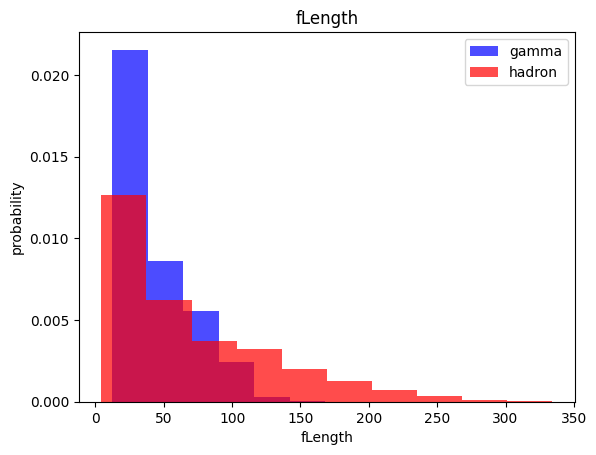

fWidth


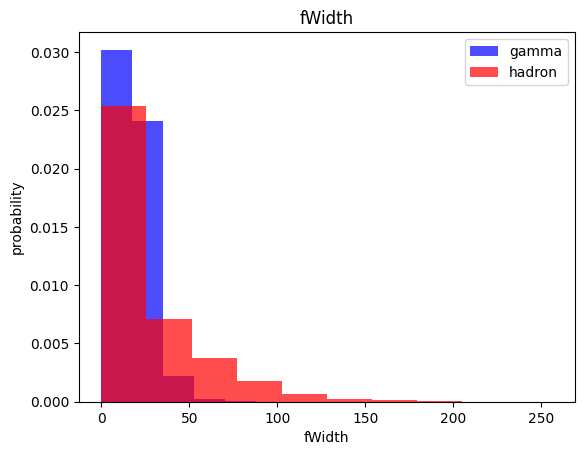

fSize


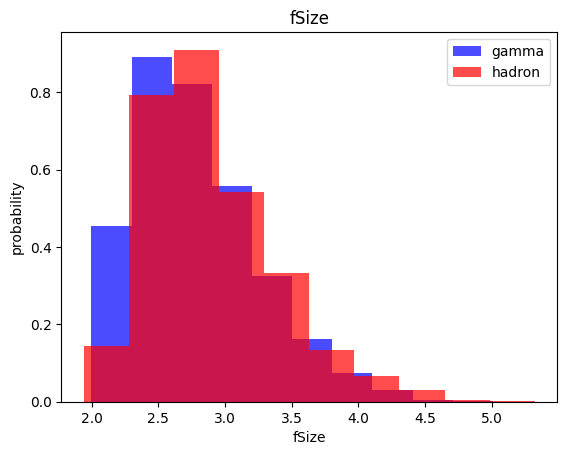

fConc


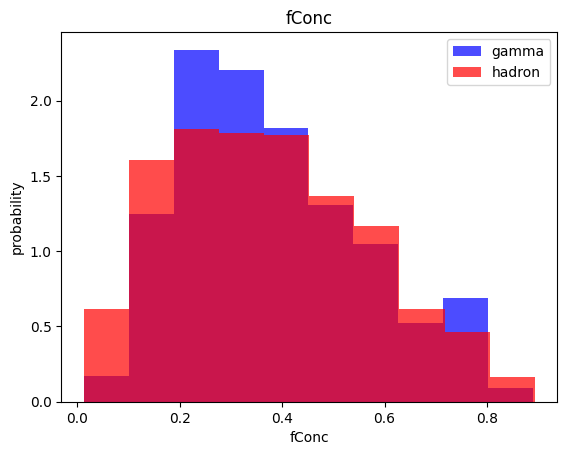

fConc1


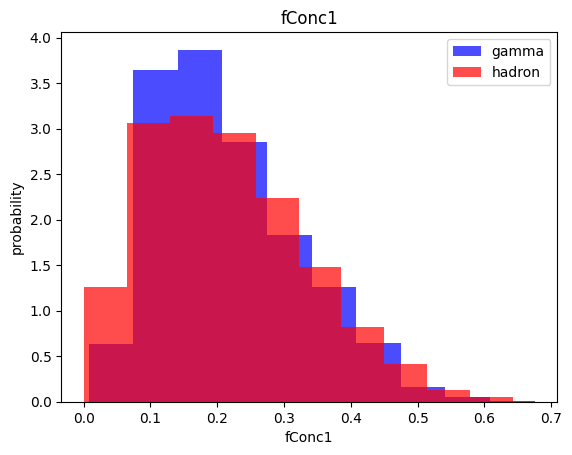

fAsym


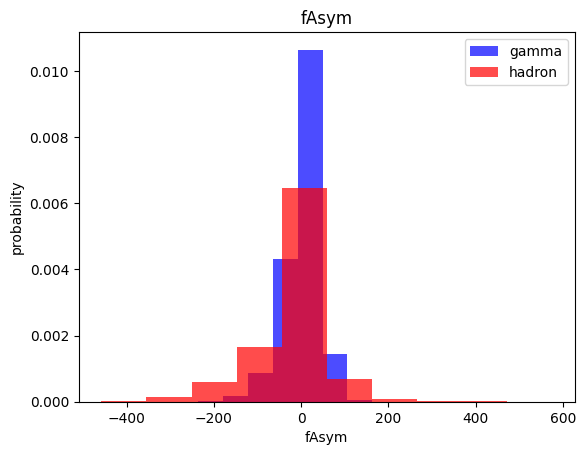

fM3Long


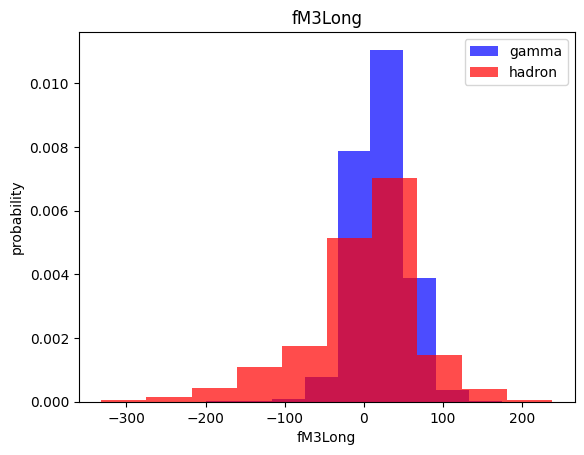

fM3Trans


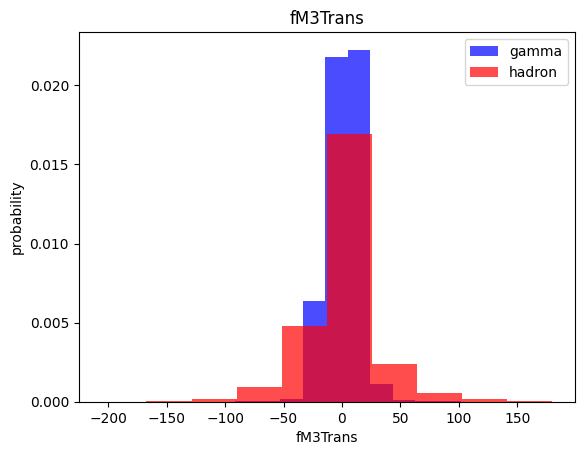

fAlpha


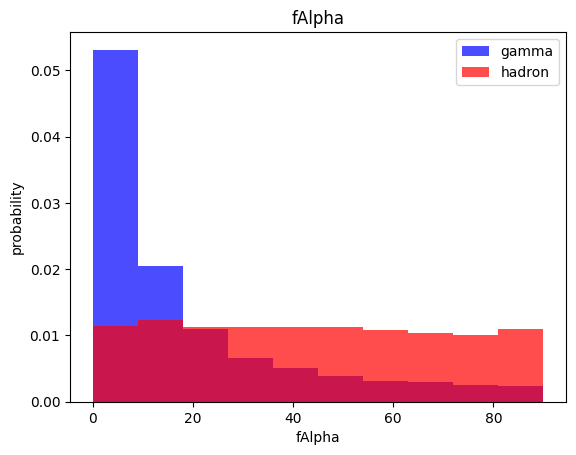

fDist


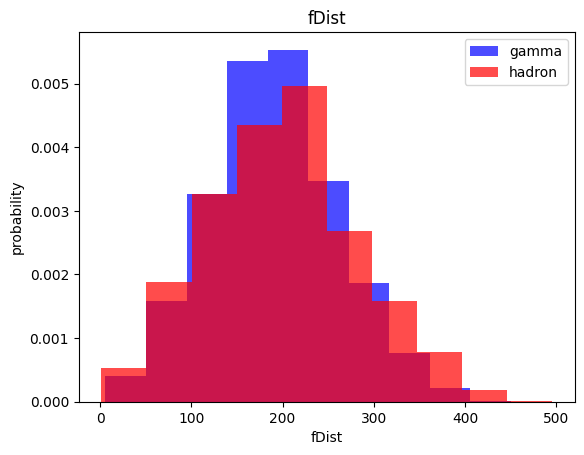

In [7]:
for label in col_names[:-1]:
    print(label)
    plt.hist(df[df['class'] == 1][label], color='blue', label='gamma', alpha=0.7, density=True)
    plt.hist(df[df['class'] == 0][label], color='red', label='hadron', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel('probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

# Train, validation, test datasets

In [8]:
# chek the shape difference between df, df.shape and df.shape(frac=1)
(
    df
    .pipe(lambda x:print(x.shape) or x)
    .pipe(lambda x:print(x.sample().shape) or x)
    .pipe(lambda x:print(x.sample(frac=1).shape))
)

(19020, 11)
(1, 11)
(19020, 11)


In [9]:
dftrain, dfvalid, dftest = np.split(
    df.sample(frac=1),          # shuffle df: sample returns a random row, frac(tion) tells the fraction of rows to return
    [
        int(0.6*len(df)),       # first cut point   : 60%
        int(0.8*len(df)),       # second cut point  : 60-80%
                                # rest of the rows  : 80-100%
    ]
)

# print shapes of the datasets
for dataset in (dftrain, dfvalid, dftest):
    print(dataset.shape)

# check we didnt miss any row
assert df.shape[0] == sum(dataset.shape[0] for dataset in [dftrain, dfvalid, dftest])


(11412, 11)
(3804, 11)
(3804, 11)


/Users/nigga/code/python/machine-leaarning/freecodecamp.org/ml-for-everybody/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# scale and oversample

## imports

In [10]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

## observe the scale ratio of values across the df

In [11]:
df.describe().loc[['std', 'min', 'max']]

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787,0.477492
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600,0.000000
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000,1.000000


## fix the data scale ratio

In [12]:
def scale_dataset(df:pd.DataFrame, data_columns:list[str], label_column:str, oversample:bool=False) -> tuple:
    
    X = df[data_columns].values     # get a 2D array of all feature comlumns
    y = df[label_column].values     # get a 1D array of the label column
    
    # print(X[:3])
    scaler = StandardScaler()
    
    X = scaler.fit_transform(X)     # fix scale ratio of the values
    
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(    # creates copies from random rows that have inferior label value total
            X,                      # data to be resampled
            y                       # labels
        )
    
    data = np.hstack((              # reassemble the 2D matrix
        X,                          # 2D feature matrix
        np.reshape(                 # we need a 2D array to stack
            y,                      # 1D array
            (
                -1,                 # rows: same as len(y)
                1                   # columns
            )
        )
    ))
    
    return data, X, y

In [13]:
train, X_train, y_train = scale_dataset(dftrain, dftrain.columns[:-1], dftrain.columns[-1])
print(train[:1], '\n\n', X_train[:1], '\n\n', y_train[:10])

[[-0.81176157 -0.42697381 -0.57896007  0.77683826  0.79268876  0.12988644
  -0.41426488 -0.1858524   2.34229101 -0.45998279  1.        ]] 

 [[-0.81176157 -0.42697381 -0.57896007  0.77683826  0.79268876  0.12988644
  -0.41426488 -0.1858524   2.34229101 -0.45998279]] 

 [1 1 1 1 1 1 1 1 1 0]


## observe the ratio between the number of gammas and hadrons

In [14]:
# observe on np.array
total_rows = len(train)
# total_gammas = len(train[train['class']==1])
total_gammas = len(train[train[:,-1]==1])
total_gamma_labels = sum(y_train == 1)
# total_hadrons = len(train[train['class']==0])
total_hadrons = len(train[train[:,-1]==0])
total_hadron_labels = sum(y_train == 0)
gamma_ratio = total_gammas / total_rows
hadron_ratio = total_hadrons / total_rows
print(total_rows)
print(total_gammas, total_gamma_labels, f'{gamma_ratio:.2%}')
print(total_hadrons, total_hadron_labels, f'{hadron_ratio:.2%}')


11412
7403 7403 64.87%
4009 4009 35.13%


## oversample the lesser subset to make them the same

In [15]:
train, X_train, y_train = scale_dataset(dftrain, dftrain.columns[:-1], dftrain.columns[-1], oversample=True)


## observe AGAIN the ratio between the number of gammas and hadrons

In [16]:
# observe on np.array
total_rows = len(train)
# total_gammas = len(train[train['class']==1])
total_gammas = len(train[train[:,-1]==1])
total_gamma_labels = sum(y_train == 1)
# total_hadrons = len(train[train['class']==0])
total_hadrons = len(train[train[:,-1]==0])
total_hadron_labels = sum(y_train == 0)
gamma_ratio = total_gammas / total_rows
hadron_ratio = total_hadrons / total_rows
print(total_rows)
print(total_gammas, total_gamma_labels, f'{gamma_ratio:.2%}')
print(total_hadrons, total_hadron_labels, f'{hadron_ratio:.2%}')


14806
7403 7403 50.00%
7403 7403 50.00%


# create the actual datasets

In [17]:
train, X_train, y_train = scale_dataset(dftrain, dftrain.columns[:-1], dftrain.columns[-1], oversample=True)
valid, X_valid, y_valid = scale_dataset(dfvalid, dfvalid.columns[:-1], dfvalid.columns[-1], oversample=False)   # no oversamplling
test, X_test, y_test = scale_dataset(dftest, dftest.columns[:-1], dftest.columns[-1], oversample=False)         # no oversampling


# kNN (k-nearest neighbours)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [19]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model = knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [20]:
print(y_pred)
print(y_test)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1338
           1       0.86      0.86      0.86      2466

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



# Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

In [23]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [24]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.42      0.52      1338
           1       0.74      0.90      0.81      2466

    accuracy                           0.73      3804
   macro avg       0.71      0.66      0.66      3804
weighted avg       0.72      0.73      0.71      3804



# Log Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)

In [27]:
y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1338
           1       0.84      0.81      0.83      2466

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.76      3804
weighted avg       0.78      0.78      0.78      3804



# Support Vector Machines

In [28]:
from sklearn.svm import SVC

In [29]:
svm_model = SVC().fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1338
           1       0.89      0.91      0.90      2466

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



# # # # # # # # # # # # # # # # # # # # # # # # #
# Neural Networks
# # # # # # # # # # # # # # # # # # # # # # # # #


In [30]:
import tensorflow as tf

In [31]:
nn_model = tf.keras.Sequential([
    # tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),  # deprecated
    tf.keras.Input(shape=(10,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [32]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()



In [33]:
history = nn_model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=False
)

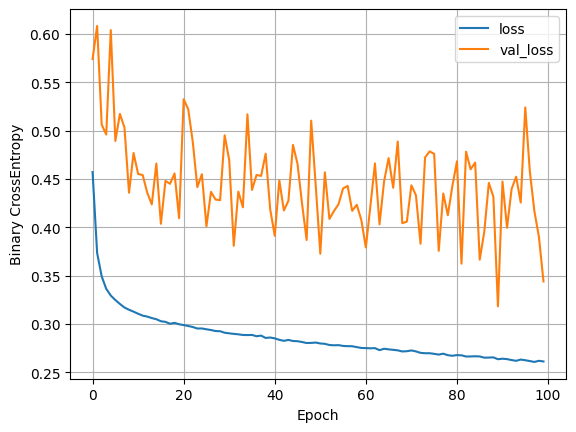

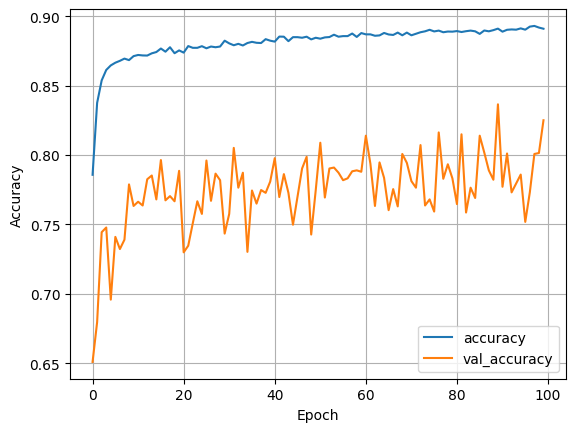

In [34]:
plot_loss(history)
plot_accuracy(history)